In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip asl-alphabet.zip -d /content/asl_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  

In [ ]:

!ls /content/asl_data/asl_alphabet_test/

!ls /content/asl_data/asl_alphabet_train/


asl_alphabet_test
asl_alphabet_train


In [ ]:
import os
print(os.listdir("/content/asl_data"))


['asl_alphabet_test', 'asl_alphabet_train']


In [ ]:
DATASET_DIR = "/content/asl_data/asl_alphabet_train/asl_alphabet_train"


In [ ]:
import os
import cv2

bad_images = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                bad_images.append(img_path)
                os.remove(img_path)
        except:
            bad_images.append(img_path)
            os.remove(img_path)

print(f"Removed {len(bad_images)} corrupted images")


Removed 0 corrupted images


In [ ]:
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None and len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            cv2.imwrite(img_path, img)


In [ ]:
from collections import Counter

class_counts = {}

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

print(class_counts)


{'X': 3000, 'M': 3000, 'J': 3000, 'O': 3000, 'Z': 3000, 'L': 3000, 'nothing': 3000, 'Y': 3000, 'B': 3000, 'G': 3000, 'U': 3000, 'Q': 3000, 'W': 3000, 'E': 3000, 'N': 3000, 'T': 3000, 'space': 3000, 'C': 3000, 'R': 3000, 'P': 3000, 'del': 3000, 'V': 3000, 'S': 3000, 'K': 3000, 'D': 3000, 'A': 3000, 'H': 3000, 'I': 3000, 'F': 3000}


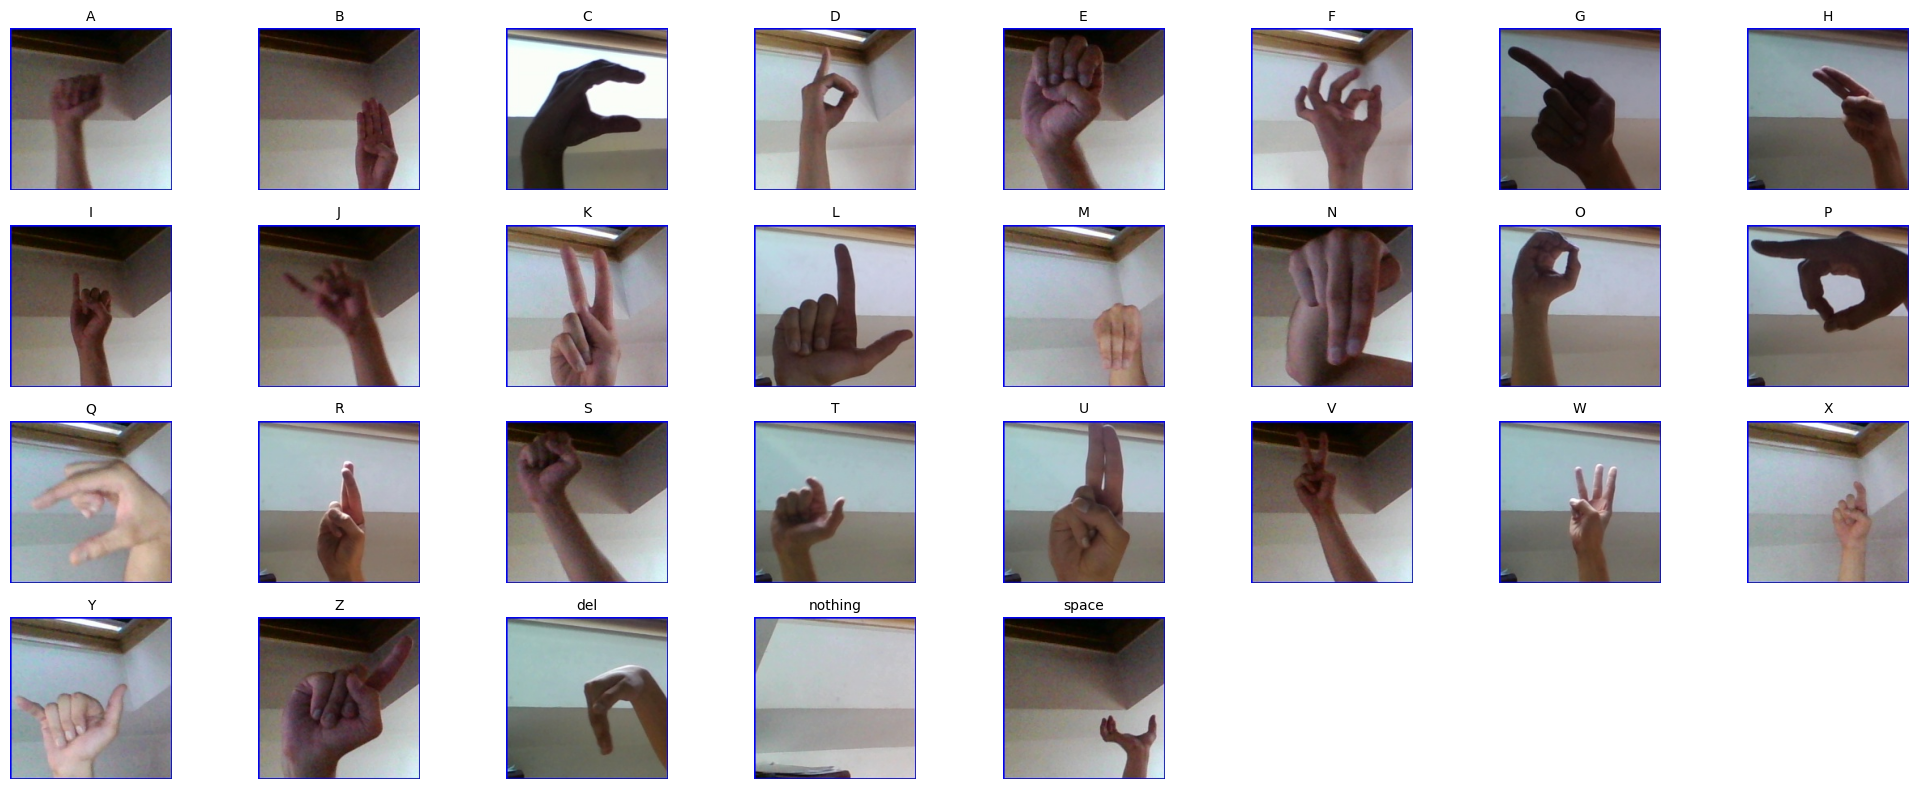

In [ ]:
import os, cv2, matplotlib.pyplot as plt

train_path = "/content/asl_data/asl_alphabet_train/asl_alphabet_train"

classes = sorted([
    c for c in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, c))
])

num_classes = len(classes)
cols = 8  # عدد الأعمدة
rows = (num_classes // cols) + 1

plt.figure(figsize=(20, rows * 2))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)

    images = [f for f in os.listdir(cls_path)
              if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    if len(images) == 0:
        continue

    img = cv2.imread(os.path.join(cls_path, images[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
train_dir = "/content/asl_data/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/content/asl_data/asl_alphabet_test/asl_alphabet_test"

IMG_SIZE = (224, 224)   # ResNet50
BATCH_SIZE = 32


In [ ]:
import os
print(os.listdir(train_dir)[:10])


['X', 'M', 'J', 'O', 'Z', 'L', 'nothing', 'Y', 'B', 'G']


**Data Generators**

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
input_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,     #Normalization بيعدل القيم
    rotation_range=15,          #يلف الصور 15د
    zoom_range=0.15,             # يعمل ZOOM IN
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2   # 👈 المهم
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",     # 👈 مهم
    shuffle=True
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",   # 👈 مهم
    shuffle=False
)


num_classes = train_generator.num_classes
print("Number of classes:", num_classes)


Found 69600 images belonging to 29 classes.
Found 0 images belonging to 0 classes.
Found 17400 images belonging to 29 classes.
Number of classes: 29


**Base Model**

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze

**Custom Head**

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

**Compile**

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Fine-Tuning**

In [ ]:
print(" Fine Tuning Started...")

base_model.trainable = True

# فك آخر 50 layer بس
for layer in base_model.layers[:-50]:
    layer.trainable = False


 Fine Tuning Started...


**Training**

In [ ]:
history = model.fit(
    train_generator,
    epochs=10
)



Epoch 1/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1138s 410ms/step - accuracy: 0.8660 - loss: 0.4859
Epoch 2/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1097s 404ms/step - accuracy: 0.9881 - loss: 0.0446
Epoch 3/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1105s 406ms/step - accuracy: 0.9921 - loss: 0.0289
Epoch 4/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1098s 404ms/step - accuracy: 0.9948 - loss: 0.0201
Epoch 5/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1099s 404ms/step - accuracy: 0.9944 - loss: 0.0201
Epoch 6/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1094s 402ms/step - accuracy: 0.9965 - loss: 0.0138
Epoch 7/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1107s 407ms/step - accuracy: 0.9962 - loss: 0.0148
Epoch 8/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1165s 408ms/step - accuracy: 0.9975 - loss: 0.0098
Epoch 9/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1098s 404ms/step - accuracy: 0.9970 - loss: 0.0128
Epoch 10/10
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 1106s 407ms/step - accuracy: 0.9977 - loss: 0.0089


In [ ]:
model.save("/content/asl_resnet50_model")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/asl_resnet50_model.keras")


**Testing**

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)

print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)


544/544 ━━━━━━━━━━━━━━━━━━━━ 235s 422ms/step - accuracy: 0.9984 - loss: 0.0074
Validation Accuracy: 0.9979885220527649
Validation Loss: 0.008700837381184101


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Predictions
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = val_generator.classes

# Class names
class_names = list(val_generator.class_indices.keys())

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))


544/544 ━━━━━━━━━━━━━━━━━━━━ 231s 416ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       600
           B       1.00      1.00      1.00       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       1.00      1.00      1.00       600
           F       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      1.00      1.00       600
           J       1.00      1.00      1.00       600
           K       1.00      0.99      1.00       600
           L       1.00      1.00      1.00       600
           M       1.00      0.97      0.99       600
           N       0.98      1.00      0.99       600
           O       1.00      1.00      1.00       600
           P       1.00      1.00      1.00       600
           Q       1.00      1.00   

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)


544/544 ━━━━━━━━━━━━━━━━━━━━ 210s 386ms/step


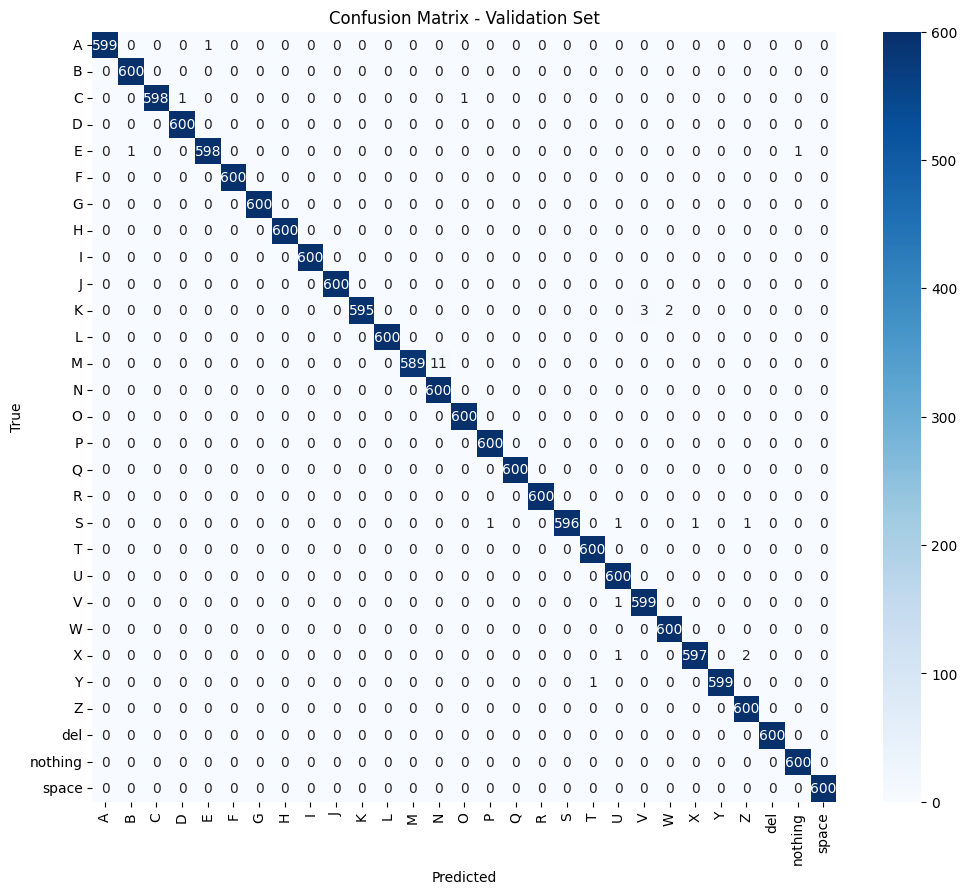

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.show()
